In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder




In [ ]:
df = pd.read_csv('/kaggle/input/gps-trajectories/trajFeatures.csv') #load the dataset # here training is done in kaggle for GPU's dependency
df = df.loc[df['Label-state'] != 'Unlabelled'] 
df.loc[df['Mode of Transport']=='taxi','Mode of Transport'] = 'car' # group taxis and cars

for column in df.columns:
    if 'Unnamed' in column:
        df.drop(column, axis=1, inplace=True)

modes = np.array(df['Mode of Transport'])

# Encoding modes of transport from here: bit.ly/2LdtVjV (see here also for inverse encoding)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(modes)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
modes = onehot_encoder.fit_transform(integer_encoded)

feature_drop = ['Mode of Transport','Path','Label-state', 'Point Count', 'Duration','Length', 'Turning-angle/Time','Hurst Exponent']

features = list(df.drop(feature_drop, axis=1).columns)

# Input/output data
X = np.array(df.drop(feature_drop, axis=1))
Y = modes

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
np.array(df['Mode of Transport'].unique())


array(['train', 'walk', 'car', 'bus', 'subway', 'airplane', 'bike',
       'boat', 'run', 'motorcycle'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(  X, Y, test_size=0.33, random_state=42)

In [ ]:
def fc_block(inputs, output_channels, dropout=0.2):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x
#model1 
def get_model(n_labels=10, init_fc=512, n_blocks=2, _dropout_1=0.2, _dropout_2=0.6, flat_frame_len=3258):
    _inputs = tf.keras.layers.Input(shape=(8,))
    x = _inputs
    
    # Define layers
    for i in range(n_blocks):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=_dropout_1 if (1+i)!=n_blocks else _dropout_2
        )
    
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

model = get_model()
model.compile(tf.keras.optimizers.Adam(0.000333), "categorical_crossentropy", metrics="acc")
model.summary()

# tf.keras.utils.plot_model(model)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 512)               4608      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [ ]:
cb_list = [
    
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
]
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=cb_list, batch_size=50) 

Epoch 1/100
105/105 [==============================] - 3s 11ms/step - loss: 1.8762 - acc: 0.4470 - val_loss: 2.0809 - val_acc: 0.2414 - lr: 3.3300e-04
Epoch 2/100
105/105 [==============================] - 1s 8ms/step - loss: 1.5648 - acc: 0.5064 - val_loss: 2.3155 - val_acc: 0.2286 - lr: 3.3300e-04
Epoch 3/100
104/105 [============================>.] - ETA: 0s - loss: 1.4613 - acc: 0.5302
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000266400002874434.
105/105 [==============================] - 1s 8ms/step - loss: 1.4635 - acc: 0.5294 - val_loss: 2.1870 - val_acc: 0.2201 - lr: 3.3300e-04
Epoch 4/100
105/105 [==============================] - 1s 8ms/step - loss: 1.3863 - acc: 0.5344 - val_loss: 2.2379 - val_acc: 0.2197 - lr: 2.6640e-04
Epoch 5/100
 97/105 [==========================>...] - ETA: 0s - loss: 1.3184 - acc: 0.5392
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00021311999298632145.
105/105 [==============================] - 1s 7ms/step - loss: 1.3250 - acc

In [ ]:
lstm_reslt = model.predict(X_test)

print(lstm_reslt[0]) # probablities of each class for 1st row 
print(np.argmax(lstm_reslt[0])) # max prob predicted  class is 3
print(np.max(lstm_reslt[0])) # with 0.23 predicted % 



81/81 [==============================] - 0s 2ms/step
[0.00551317 0.12910192 0.00677927 0.24267392 0.1878804  0.00712329
 0.00798614 0.1418976  0.02694948 0.24409483]
9
0.24409483


In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [ ]:


print(np.mean(history.history['acc']))
print(np.mean(history.history['val_acc']))

print(np.mean(history.history['loss']))
print(np.mean(history.history['val_loss']))

0.5837401762604714
0.406874023526907
1.133734872341156
1.6001897847652435


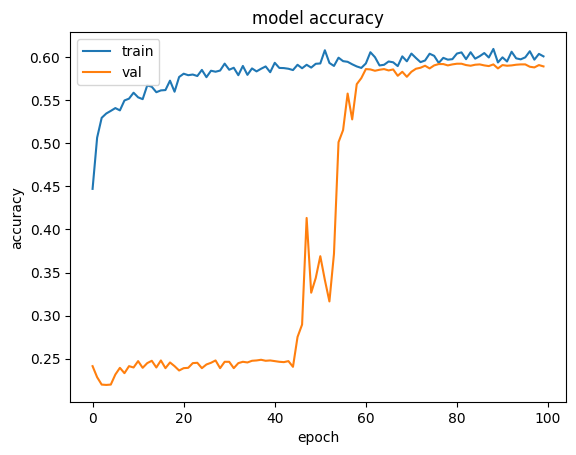

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

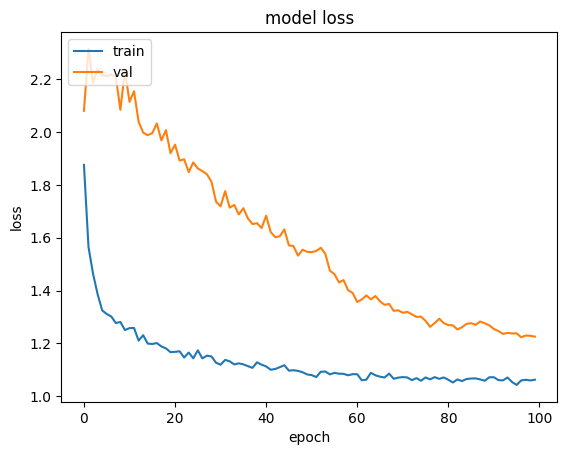

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(  X, Y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((5219, 8), (5219, 10))

In [ ]:
X_train_ = X_train.reshape( 5219 , 1, 8  )
X_test_ = X_test.reshape( 2572 , 1, 8  )



# y_train_ = y_train.reshape(5219 , 1, 8)
# y_test_ = y_test.reshape(2572 , 1, 8  )




In [ ]:
X_train_.shape, X_test_.shape

((5219, 1, 8), (2572, 1, 8))

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(1,8))))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=10,activation="softmax"))

# Compiling the RNN
regressor.compile(tf.keras.optimizers.Adam(0.000333), "categorical_crossentropy", metrics="acc")
# Fitting to the training set
history = regressor.fit(X_train_, y_train,validation_split=0.3, epochs=100, batch_size=20, verbose=2)

Epoch 1/100
183/183 - 14s - loss: 1.9500 - acc: 0.3904 - val_loss: 1.3006 - val_acc: 0.5287 - 14s/epoch - 76ms/step
Epoch 2/100
183/183 - 1s - loss: 1.2548 - acc: 0.5042 - val_loss: 1.1516 - val_acc: 0.5281 - 1s/epoch - 8ms/step
Epoch 3/100
183/183 - 1s - loss: 1.1923 - acc: 0.5302 - val_loss: 1.1102 - val_acc: 0.5990 - 1s/epoch - 8ms/step
Epoch 4/100
183/183 - 1s - loss: 1.1684 - acc: 0.5333 - val_loss: 1.0931 - val_acc: 0.5830 - 1s/epoch - 8ms/step
Epoch 5/100
183/183 - 1s - loss: 1.1596 - acc: 0.5431 - val_loss: 1.0851 - val_acc: 0.5830 - 1s/epoch - 8ms/step
Epoch 6/100
183/183 - 1s - loss: 1.1569 - acc: 0.5360 - val_loss: 1.0791 - val_acc: 0.6009 - 1s/epoch - 8ms/step
Epoch 7/100
183/183 - 2s - loss: 1.1464 - acc: 0.5417 - val_loss: 1.0795 - val_acc: 0.6003 - 2s/epoch - 9ms/step
Epoch 8/100
183/183 - 2s - loss: 1.1373 - acc: 0.5593 - val_loss: 1.0725 - val_acc: 0.5990 - 2s/epoch - 10ms/step
Epoch 9/100
183/183 - 2s - loss: 1.1383 - acc: 0.5552 - val_loss: 1.0693 - val_acc: 0.6003 -

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(1,8))))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=10))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
# Fitting to the training set
history = regressor.fit(X_train_, y_train,validation_split=0.3, epochs=25, batch_size=20, verbose=2)

Epoch 1/25
183/183 - 15s - loss: 0.0677 - accuracy: 0.4760 - val_loss: 0.0581 - val_accuracy: 0.5268 - 15s/epoch - 79ms/step
Epoch 2/25
183/183 - 2s - loss: 0.0600 - accuracy: 0.5382 - val_loss: 0.0557 - val_accuracy: 0.6022 - 2s/epoch - 9ms/step
Epoch 3/25
183/183 - 2s - loss: 0.0582 - accuracy: 0.5645 - val_loss: 0.0559 - val_accuracy: 0.5798 - 2s/epoch - 9ms/step
Epoch 4/25
183/183 - 2s - loss: 0.0579 - accuracy: 0.5653 - val_loss: 0.0550 - val_accuracy: 0.5888 - 2s/epoch - 9ms/step
Epoch 5/25
183/183 - 2s - loss: 0.0575 - accuracy: 0.5738 - val_loss: 0.0548 - val_accuracy: 0.5945 - 2s/epoch - 9ms/step
Epoch 6/25
183/183 - 2s - loss: 0.0571 - accuracy: 0.5746 - val_loss: 0.0543 - val_accuracy: 0.5945 - 2s/epoch - 10ms/step
Epoch 7/25
183/183 - 2s - loss: 0.0567 - accuracy: 0.5688 - val_loss: 0.0548 - val_accuracy: 0.5932 - 2s/epoch - 9ms/step
Epoch 8/25
183/183 - 2s - loss: 0.0563 - accuracy: 0.5721 - val_loss: 0.0550 - val_accuracy: 0.6028 - 2s/epoch - 9ms/step
Epoch 9/25
183/183 -

In [ ]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 1, 100)           23600     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_7 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                      

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:

print(np.mean(history.history['accuracy']))
print(np.mean(history.history['val_accuracy']))

print(np.mean(history.history['loss']))
print(np.mean(history.history['val_loss']))

0.5717054438591004
0.5897828841209412
0.05678953781723976
0.054476833939552306


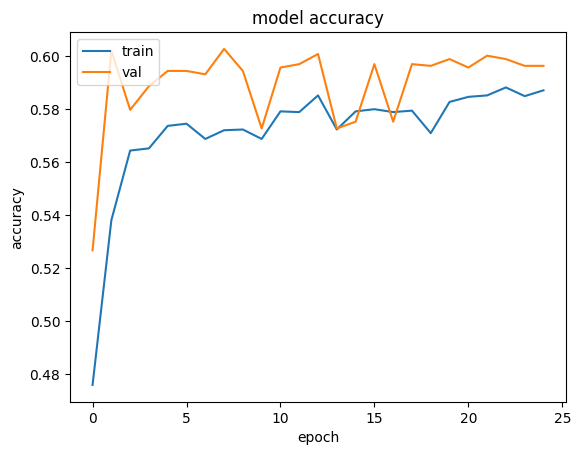

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

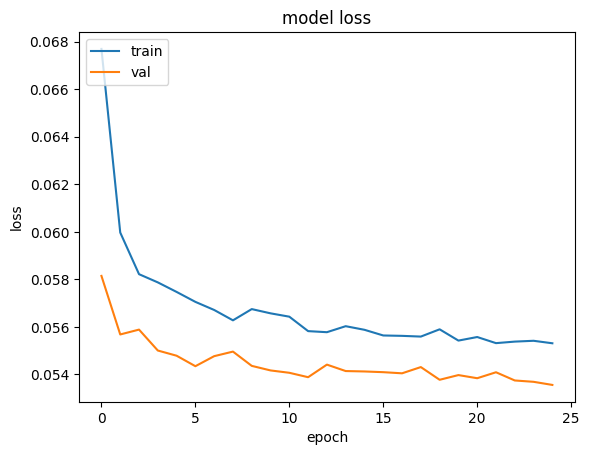

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
lstm_reslt = regressor.predict(X_test_)

81/81 [==============================] - 3s 3ms/step


In [ ]:
print(lstm_reslt[0]) # probablities of each class for 1st row 
print(np.argmax(lstm_reslt[0])) # max prob predicted  class is 1 
print(np.max(lstm_reslt[0])) # with 0.49 predicted % 

[2.1623849e-04 4.7147304e-01 7.0874987e-05 2.2410767e-01 1.2502740e-01
 4.6257682e-09 6.1852259e-12 2.6715908e-02 2.6382096e-03 1.5546650e-01]
1
0.47147304
